## Import

In [1]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from skimage import measure

original_img_dir = Path("data/assignment_3-2")
processed_img_dir = Path("data/assignemnt_3-2_processed")
final_img_dir = Path("data/assignemnt_3-2_final")
final_img_dir.mkdir(exist_ok=True, parents=True)

## Process Binarized Images

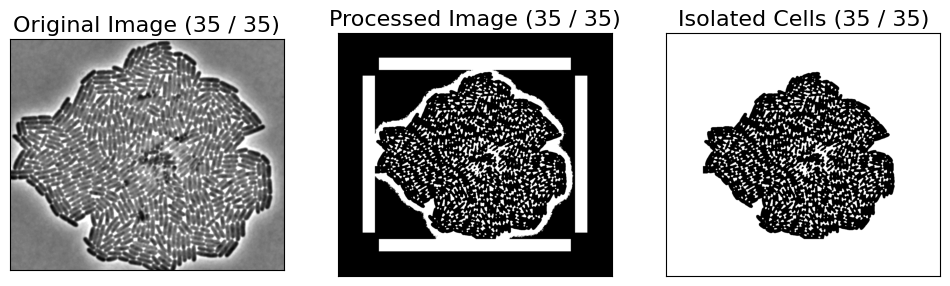

In [2]:
def plot_image(img, ax, title):
    ax.imshow(img, cmap="gray")
    ax.set_title(title, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])

num_black_pixels = []
final_imgs = []
original_imgs = list(original_img_dir.glob("*.png"))
processed_imgs = list(processed_img_dir.glob("*.png"))

for img_idx, (ori_img_path, img_path) in enumerate(zip(original_imgs, processed_imgs)):
    # Load processed images
    ori_img = cv2.imread(str(ori_img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    # Label regions and remove the largest connected component (outer background)
    labels = measure.label(img, connectivity=2, background=255)
    props = measure.regionprops(labels)
    areas = [prop.area for prop in props]
    largest_component = np.argmax(areas) + 1
    mask = np.where(labels == largest_component, 255, img)
    isolated_cells = cv2.bitwise_or(mask, img)

    # Despeckle
    kernel = np.ones((3, 3), np.uint8)
    isolated_cells = cv2.morphologyEx(isolated_cells, cv2.MORPH_CLOSE, kernel)

    # Plot figures
    num_black_pixels.append(np.sum(isolated_cells == 0))
    final_imgs.append(isolated_cells)

    cv2.imwrite(str(final_img_dir / f"{img_idx + 1}.png"), isolated_cells)

    fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
    plot_image(ori_img, ax[0], f"Original Image ({img_idx + 1} / {len(processed_imgs)})")
    plot_image(img, ax[1], f"Processed Image ({img_idx + 1} / {len(processed_imgs)})")
    plot_image(isolated_cells, ax[2], f"Isolated Cells ({img_idx + 1} / {len(processed_imgs)})")
    plt.pause(0.1)
    clear_output(wait=True)

## Estimate Doubling Time

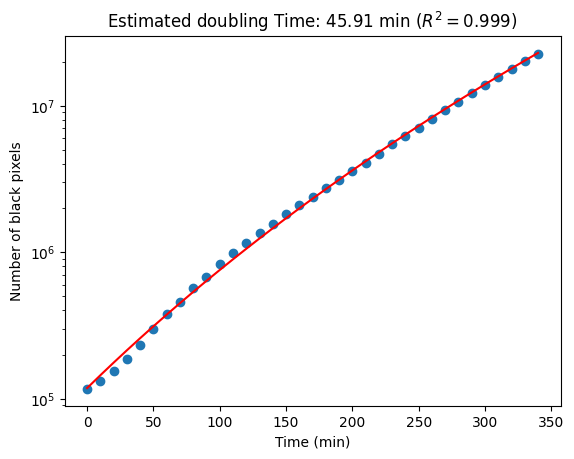

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = np.arange(0, 10*len(num_black_pixels), 10)
y = np.log10(num_black_pixels)
x_reshape = x.reshape(-1, 1)

model = LinearRegression()
model.fit(x_reshape, y)
log_y_pred = model.predict(x_reshape)

plt.scatter(x, np.power(y, 10))
plt.plot(x, np.power(log_y_pred, 10), color="red")
plt.yscale("log")
plt.xlabel("Time (min)")
plt.ylabel("Number of black pixels")
doubling_time = (np.log10(2) / model.coef_)[0]
plt.title(f"Estimated doubling Time: {doubling_time:.2f} min ($R^2={r2_score(y, log_y_pred):.3f}$)")
plt.show()